# NSMC on a simple lattice model

In [1]:
library(RSQMC)
library(mvtnorm)
library(MASS)
source("/Users/Schreuder/Google Drive/ENSAE/2A/Stage2A/RSQMC_scripts/Lattice_Model_Functions.R") 

set.seed(42)

In [2]:
# SMC parameters
D <- 4 # dimension -> DxD square
N <- 50 # number of external particles
M <- 16 # number of internal particles
T_ <- 15 # time


# AR(1) parameter
mu = 2
rho = 0.9

In [3]:
# Covariance matrix design
S_inv <- matrix(0, D**2, D**2)
tau = 1.
lambda = 1.

for(n in 1:D){
  for(k in 1:D){
    nb_neighbours = 0
    # (n,k) gives n*D + k position in vector
    vector_index <- (n-1)*D + k
    if (n > 1){ # upper neighbour
      S_inv[vector_index, vector_index - D] <- -lambda
      nb_neighbours = nb_neighbours + 1
    }
    if (n < D){ # lower neighbour
      S_inv[vector_index, vector_index + D] <- -lambda
      nb_neighbours = nb_neighbours + 1
    }
    if(k > 1){ # left neighbour
      S_inv[vector_index, vector_index - 1 ] <- -lambda 
      nb_neighbours = nb_neighbours + 1
    }
    if (k < D){ # right neighbour
      S_inv[vector_index, vector_index + 1] <- -lambda
      nb_neighbours = nb_neighbours + 1
    }
    S_inv[vector_index, vector_index] = tau + 2*nb_neighbours*lambda
  }
}

S <- solve(S_inv) # covariance matrix

In [4]:
# Trajectory simulation
x <- matrix(0, D**2, T_)
y <- matrix(0, D**2, T_)

x[, 1] <- mvrnorm(n = 1, matrix(mu, D**2), S)
for(d in 1:(D**2)){
  y[d, 1] <- rpois(1, exp(x[d, 1]))
}

for(t in 2:T_){
  x[, t] <- mu + rho*(x[, t-1]-mu) + mvrnorm(n = 1, matrix(0, D**2), S)
  for(d in 1:(D**2)){
    y[d, t] <- rpois(1, exp(x[d, t]))
  }
}

In [5]:
#### NSMC without QMC
particles <- lattice_filter(y, N, M, D, T_, mu, rho, S)

#### NSMC with QMC
particles_QMC <- lattice_filter_QMC(y, N, M, D, T_, mu, rho, S)

In [ ]:
M_values <- 5
MSE_normal = array(0, M_values)
MSE_QMC = array(0, M_values)

for(k in 3:M_values){
    # Compute MSE
    nb_filters <- 5
    for(f in 1:nb_filters){
        particles <- lattice_filter(y, N, 2**k, D, T_, mu, rho, S)
        MSE_normal[k] = MSE_normal[k] + (x[1, T_] - mean(particles[, 1, T_]))**2

        particles_QMC <- lattice_filter_QMC(y, N, 2**k, D, T_, mu, rho, S)
        MSE_QMC[k] = MSE_QMC[k] + (x[1, T_] - mean(particles_QMC[, 1, T_]))**2
    }
}

plot(MSE_normal)
lines(MSE_QMC)

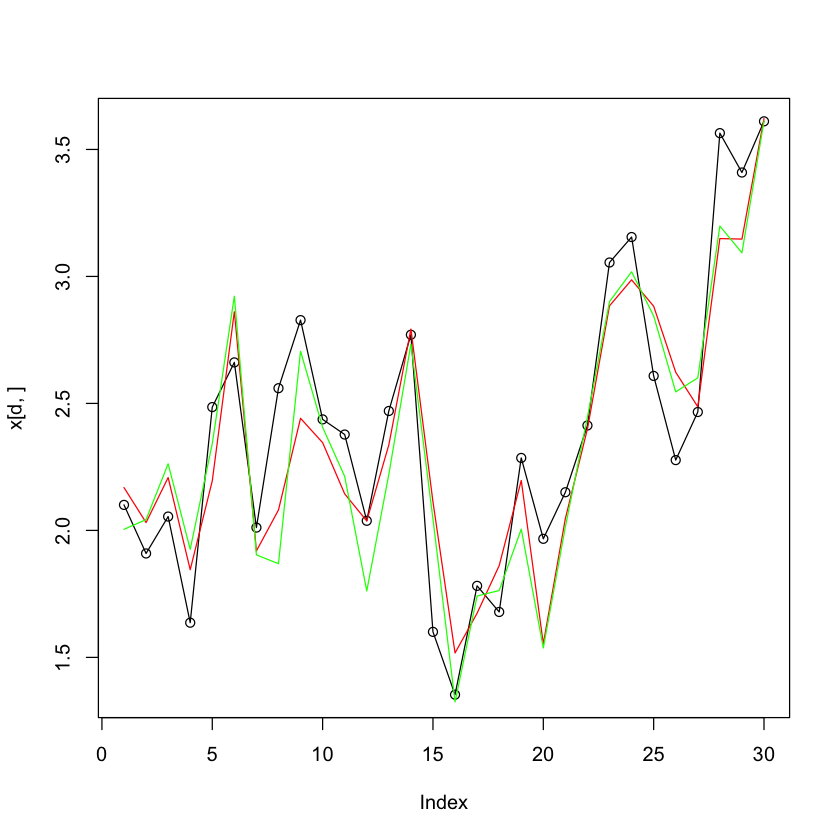

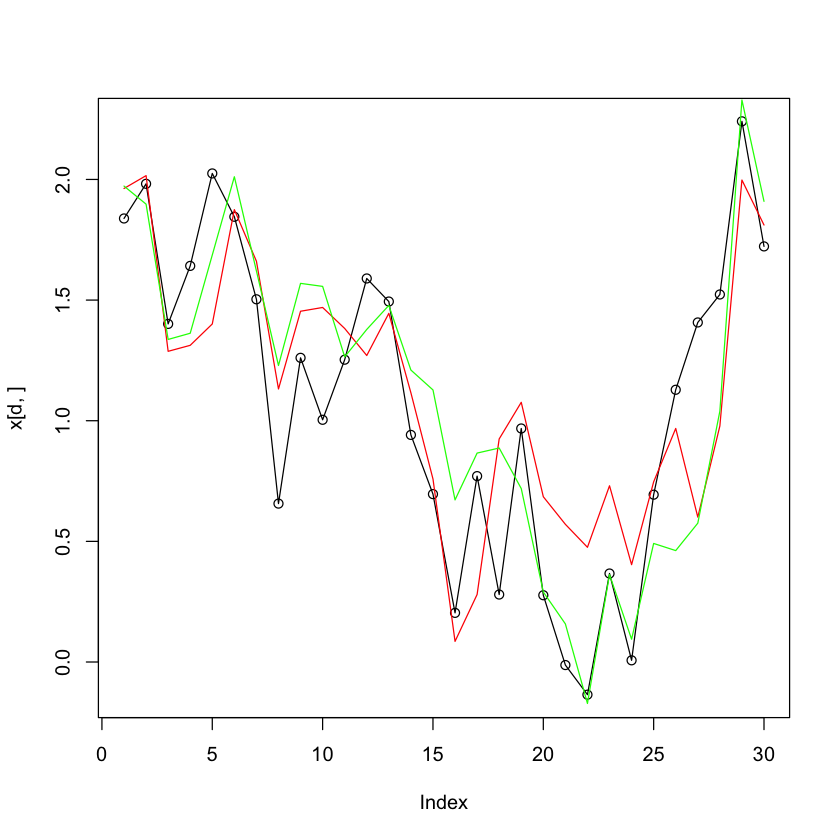

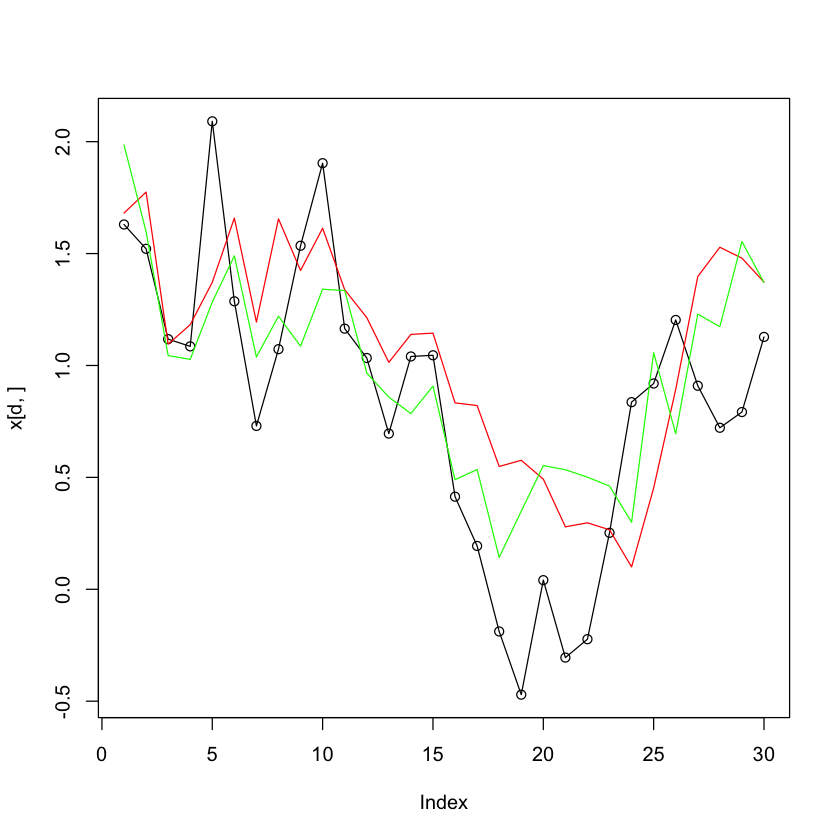

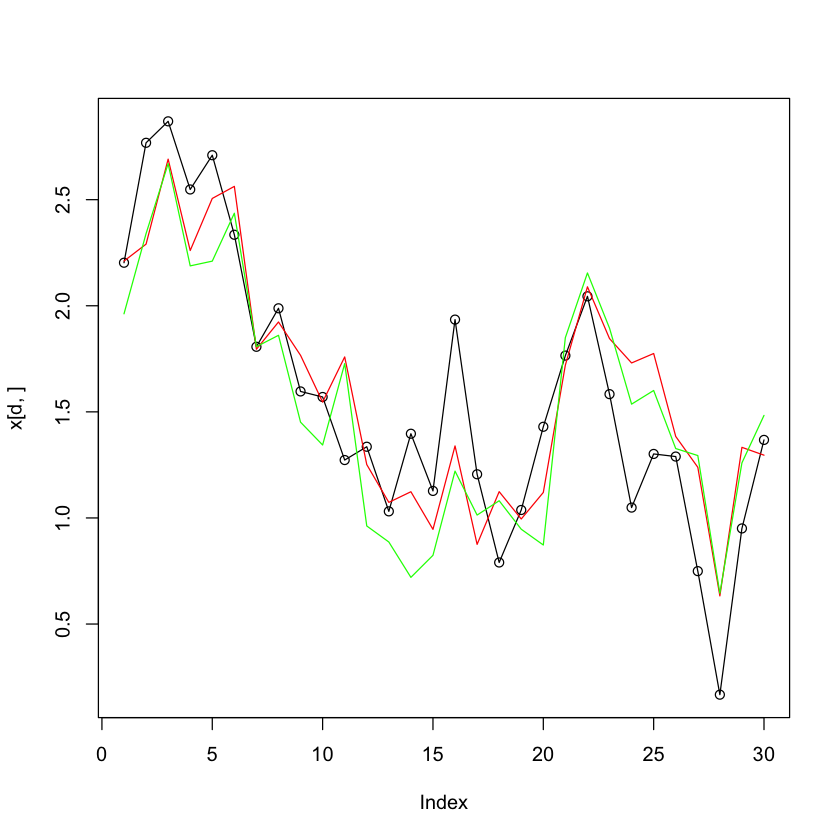

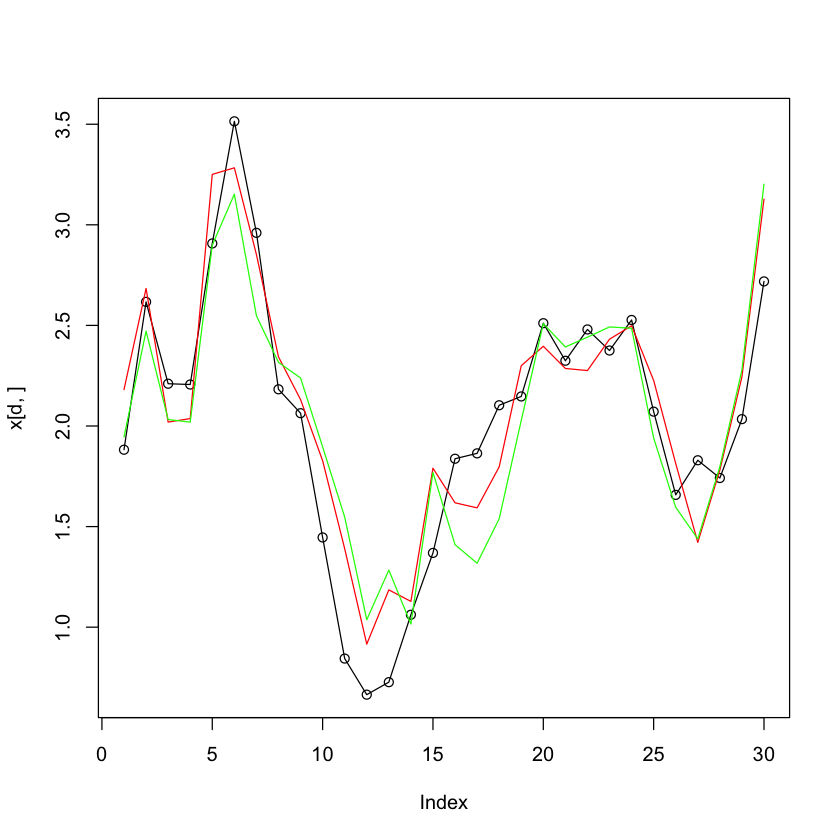

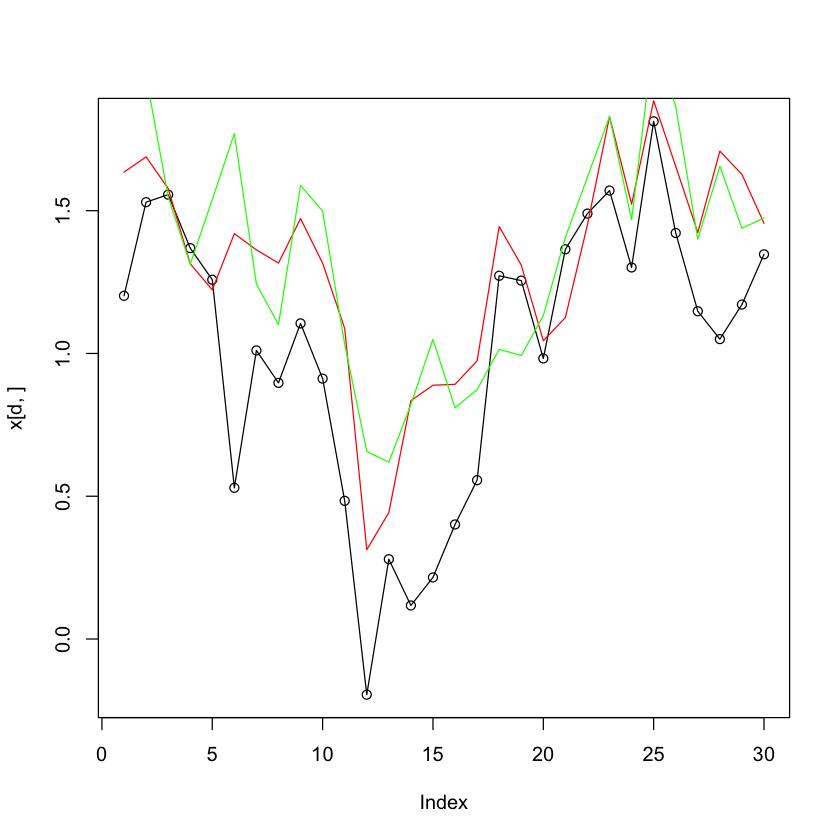

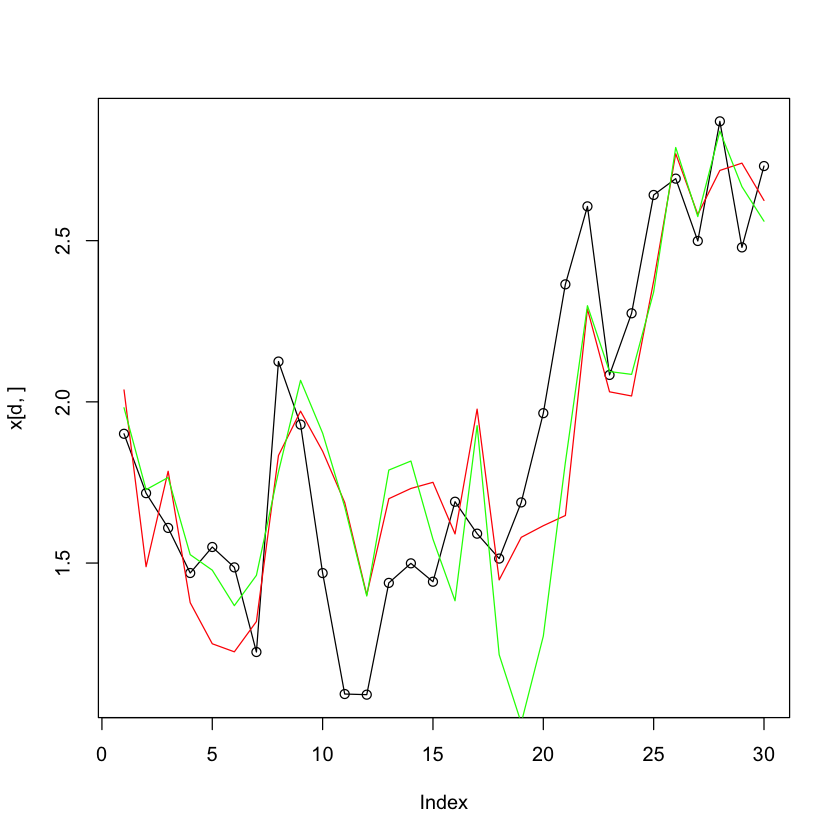

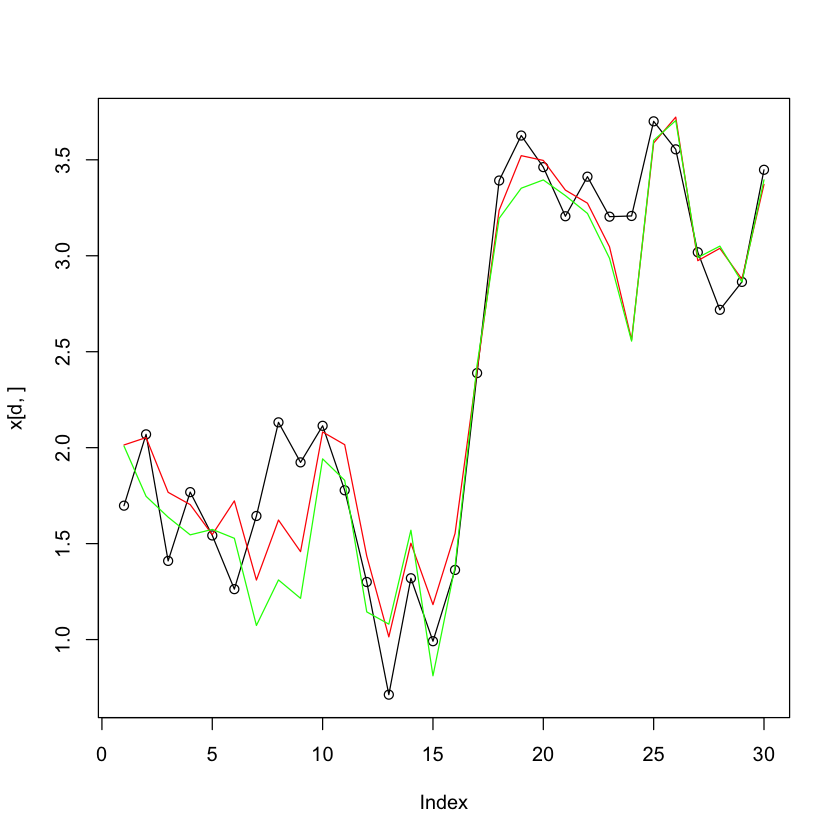

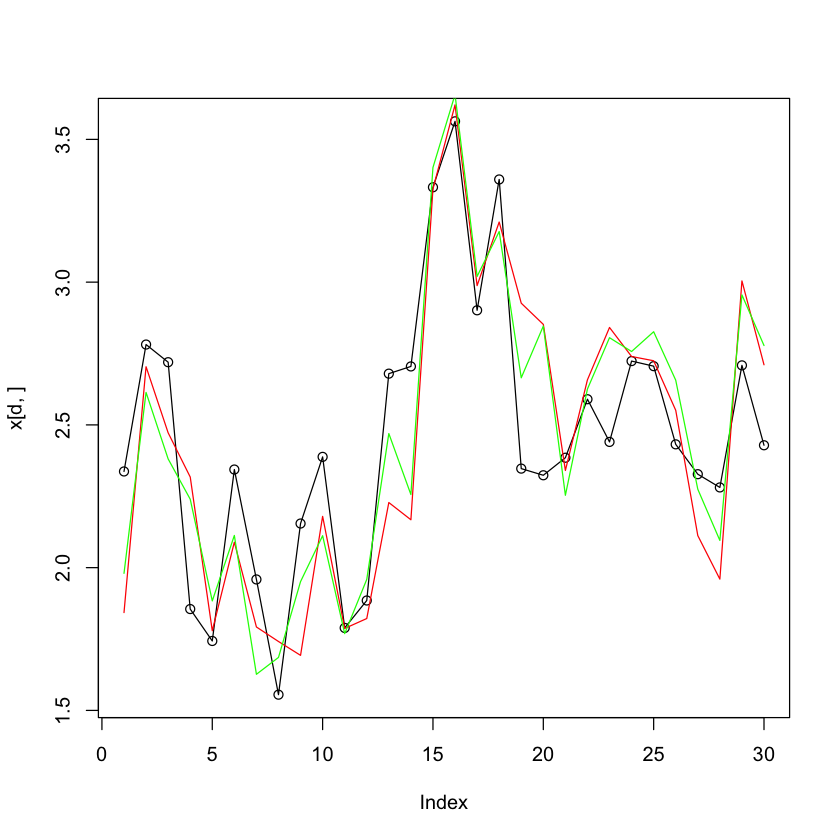

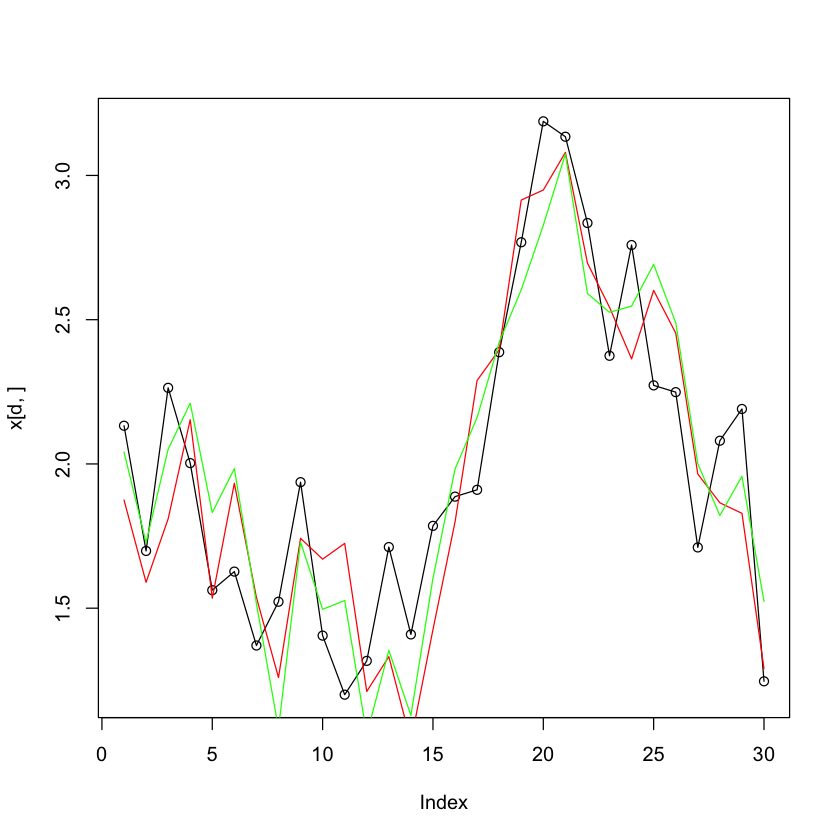

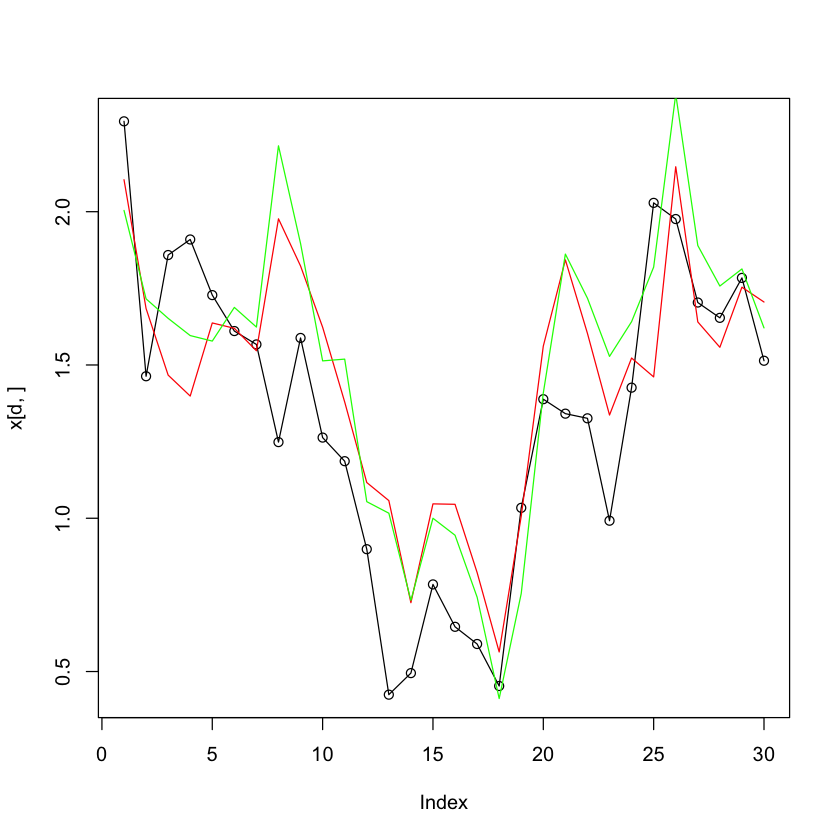

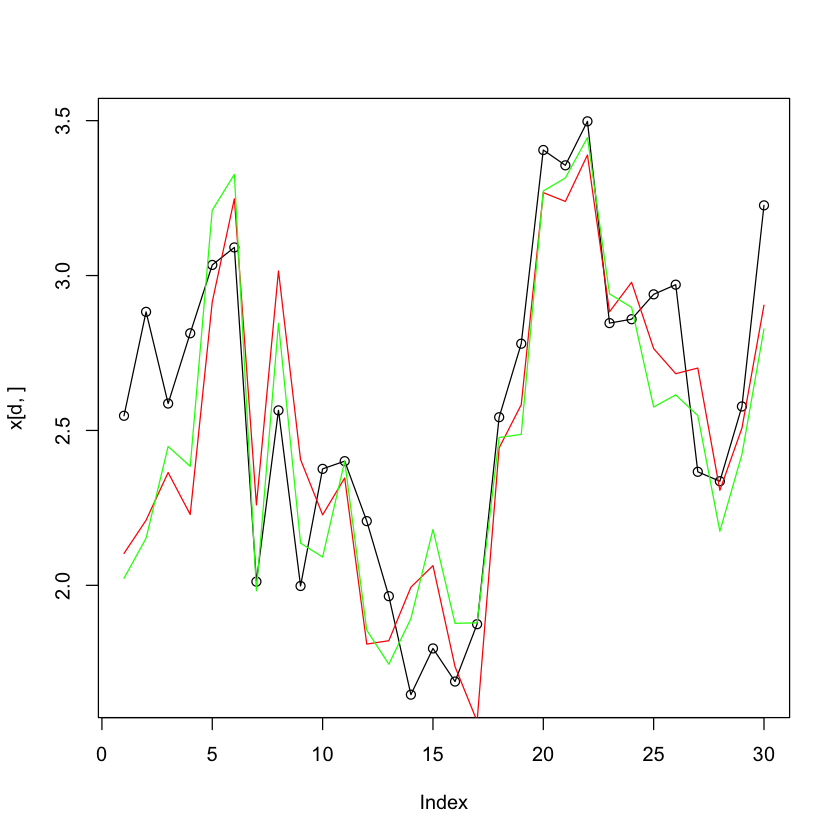

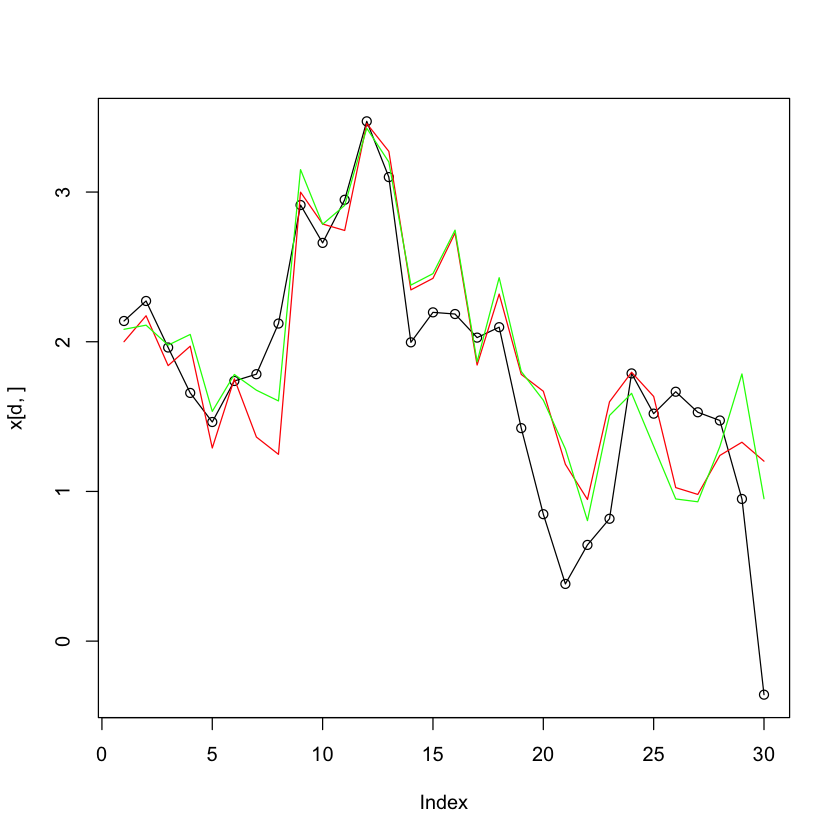

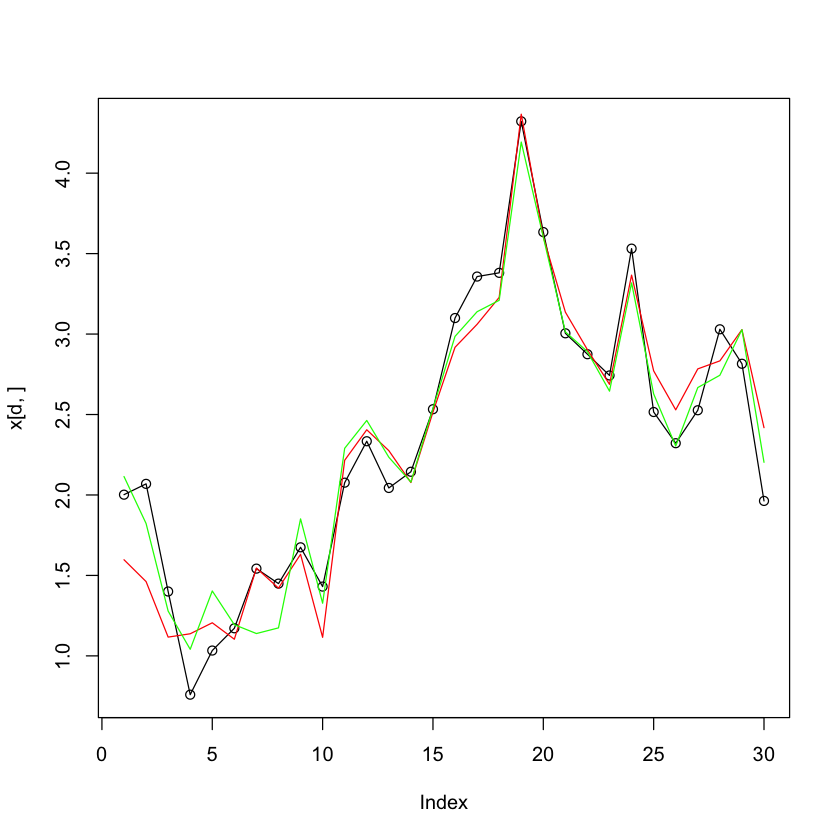

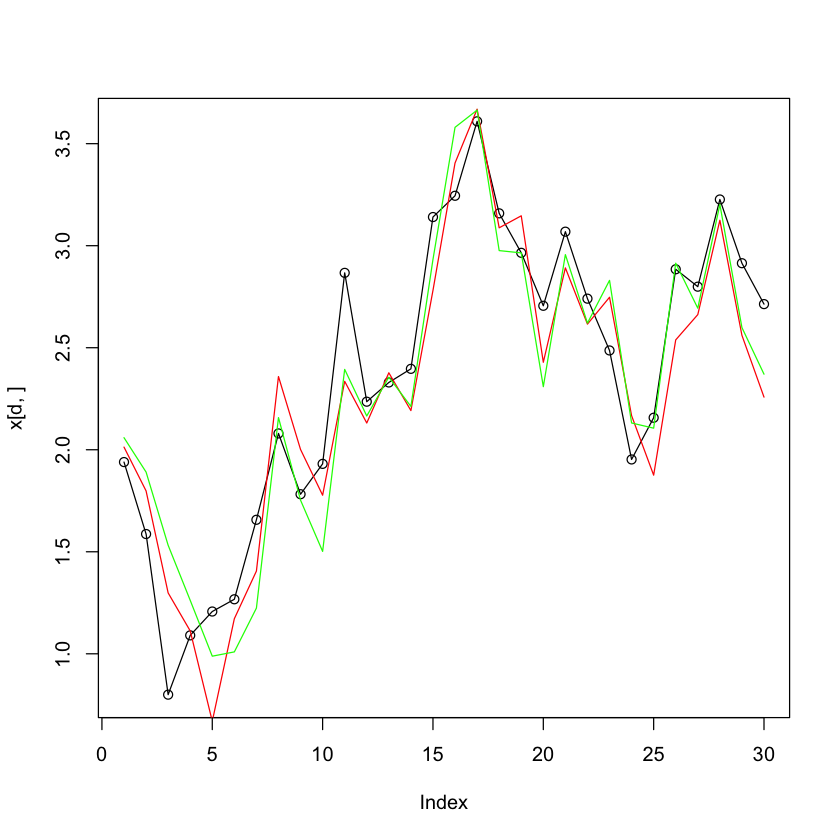

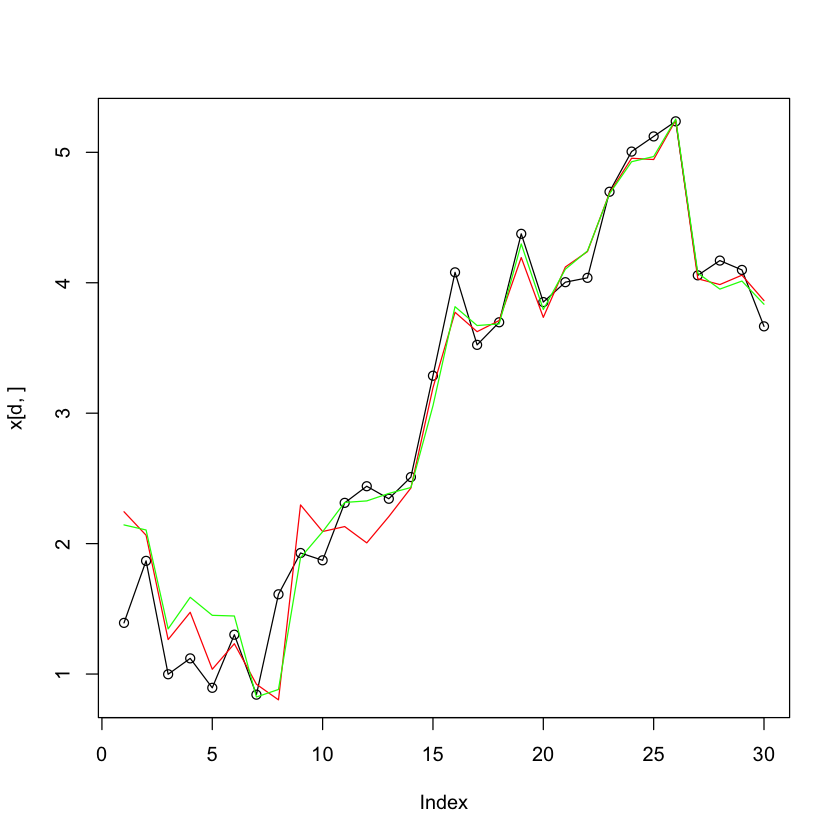

In [40]:
for(d in 1:D**2){
  plot(x[d, ])
  lines(x[d, ])
  lines(apply(particles[, d, 1:T_], 2, mean), col='red')
  lines(apply(particles_QMC[, d, 1:T_], 2, mean), col='green')
}